## Librerias

In [1]:
#pip install tensorflow

In [2]:
#pip install keras

In [21]:
import os
import glob
import cv2
import numpy as np
import random
import matplotlib.pyplot as plt
import tensorflow as tf
import math
from PIL import Image
from math import log10, sqrt

from keras.models import Sequential
from keras.layers import Convolution2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Input
from keras.layers import Dropout

from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from tensorflow import keras
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam

## Lectura de imagenes

In [22]:
def leer_imagenes_automatico(img_path):
    # Obtener lista de archivos en la carpeta
    files_names = os.listdir(img_path)
    
    # Asegurar que sea un archivo de imagen
    image_extensions = ['.tiff', '.png', '.jpg', '.jpeg']
    image_files = [file for file in files_names if os.path.splitext(file)[1].lower() in image_extensions]
    
    # Crear un diccionario donde las claves son 'ruta_imagen_1', 'ruta_imagen_2', etc.
    rutas_imagenes = {}
    for i, file in enumerate(image_files):
        ruta_imagen = os.path.join(img_path, file)
        rutas_imagenes[f"ruta_imagen_{i+1}"] = ruta_imagen
    
    return rutas_imagenes

def procesar_imagenes(rutas_imagenes):
    imagenes_procesadas = {}
    
    for nombre_variable, ruta in rutas_imagenes.items():
        input_image1 = cv2.imread(ruta, cv2.IMREAD_COLOR)  # Leer la imagen
        input_image = cv2.cvtColor(input_image1, cv2.COLOR_BGR2RGB)  # Convertir a RGB
        input_image = cv2.resize(input_image, (128, 128))
        imagenes_procesadas[nombre_variable] = input_image
    
    return imagenes_procesadas

In [23]:
img_path_no_violence = r"C:\Users\Contratista\Desktop\VisionPc\violence_dataset\non_violence"
img_path_violence = r"C:\Users\Contratista\Desktop\VisionPc\violence_dataset\violence"
rutas_imagenes_no_violence = leer_imagenes_automatico(img_path_no_violence)
rutas_imagenes_violence = leer_imagenes_automatico(img_path_violence)

imagenes_no_violence = procesar_imagenes(rutas_imagenes_no_violence)
imagenes_violence = procesar_imagenes(rutas_imagenes_violence)

In [24]:
#imagenes_no_violence

## Training - Validation - Testing

In [25]:
# Función training - testing
def split_data(data, train_size=0.7):
    split_point = int(train_size * len(data))
    return data[:split_point], data[split_point:]


In [26]:
# Data aleatorizada
#data_no_violence = [(0, img) for img in imagenes_no_violence]  # Etiqueta 0 para no violencia
data_no_violence = [(0, imagen) for _, imagen in imagenes_no_violence.items()] 
#data_violence = [(1, img) for img in imagenes_violence]  # Etiqueta 1 para violencia
data_violence = [(1, imagen) for _, imagen in imagenes_violence.items()] 
random.Random(0).shuffle(data_no_violence)
random.Random(0).shuffle(data_violence)

# Dividir no violencia y violencia en entrenamiento y prueba
train_no_violence, test_no_violence = split_data(data_no_violence)
train_violence, test_violence = split_data(data_violence)

# Training y tetsing completo aleatorizado
train_data = train_no_violence + train_violence
test_data = test_no_violence + test_violence
random.Random(0).shuffle(train_data)
random.Random(0).shuffle(test_data)

In [27]:
# Arreglos 
x_train, y_train = [], []
x_test, y_test = [], []

for i, sample in enumerate(train_data):
    label = sample[0]
    img = sample[1]
    x_train.append(img)
    y_train.append(label)

for i, sample in enumerate(test_data):
    label = sample[0]
    img = sample[1]
    x_test.append(img)
    y_test.append(label)


In [28]:
# Convertir a arreglos de NumPy para TensorFlow
x_train = np.array(x_train)
x_test = np.array(x_test)

y_train = np.array(y_train)
y_test = np.array(y_test)


In [29]:
validation_split = 0.1
val_index = int(len(x_train) * (1 - validation_split))
x_val = x_train[val_index:]
y_val = y_train[val_index:]

x_train = x_train[:val_index]
y_train = y_train[:val_index]

x_val = np.array(x_val)
y_val = np.array(y_val)
x_train = np.array(x_train)
y_train = np.array(y_train)

In [30]:
#Verificar tamaño training - testing
print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(6967, 128, 128, 3)
(775, 128, 128, 3)
(3320, 128, 128, 3)
(6967,)
(775,)
(3320,)


## One hot encoding

In [31]:
possible_labels = [0,1]
y_trainOneHot = tf.one_hot(y_train, len(possible_labels))
y_valOneHot = tf.one_hot(y_val, len(possible_labels))
y_testOneHot = tf.one_hot(y_test, len(possible_labels))

## Red neuronal convolucional

Se construye y retorna una Red Neuronal Convolucional (CNN) con el siguiente flujo:

Capas convolucionales: Se utilizan varias capas convolucionales, cada una de ellas seguida por:
- Activación ReLU: Función de activación que introduce no linealidades en el modelo.
- Normalización por lotes (Batch Normalization): Ayuda a estabilizar y acelerar el entrenamiento normalizando la activación de cada capa.
- Max-Pooling: Reduce las dimensiones de las características, manteniendo las más relevantes y reduciendo el tamaño del modelo.
- Capas densas: Después de extraer las características mediante las capas convolucionales, se añaden capas densas (fully connected) para realizar la clasificación final.

Regularización L2: Se aplica para reducir el riesgo de sobreajuste, penalizando los pesos excesivamente grandes.

- Compilación del modelo: Se usa el optimizador Adam (Adaptive Moment Estimation), que ajusta los pesos del modelo de manera eficiente durante el entrenamiento. La función de pérdida utilizada es la entropía cruzada categórica, adecuada para problemas de clasificación multiclase.


Tomado de https://www.kaggle.com/code/kevinprieto20/deteccion-violencia/notebook#Insertando-los-datos-(training,-validacion-y-testing)-en-arrays-de-numpy


In [40]:
def cnn_model():
    model = Sequential()  # Modelo secuencial
    model.add(Input(shape=(128, 128, 3)))  # Capa de entrada para imágenes de AxA con 3 canales (RGB)
    
    # Primera capa convolucional
    model.add(Convolution2D(16, (3, 3), activation="relu", kernel_regularizer=l2(0.001)))  # 32 filtros 3x3, ReLU, regularización L2
    model.add(BatchNormalization())  # Normalización por lotes
    model.add(MaxPooling2D(pool_size=(2, 2)))  # Max-pooling para reducir dimensiones
    
    # Segunda capa convolucional
    model.add(Convolution2D(32, (3, 3), activation="relu", kernel_regularizer=l2(0.001)))  # 64 filtros 3x3, ReLU, regularización L2
    model.add(BatchNormalization())  # Normalización por lotes
    model.add(MaxPooling2D(pool_size=(2, 2)))  # Max-pooling para reducir dimensiones
    
    # Tercera capa convolucional
    model.add(Convolution2D(64, (3, 3), activation="relu", kernel_regularizer=l2(0.001)))  # 128 filtros 3x3, ReLU, regularización L2
    model.add(BatchNormalization())  # Normalización por lotes
    model.add(MaxPooling2D(pool_size=(2, 2)))  # Max-pooling para reducir dimensiones
    
    # Cuarta capa convolucional
    model.add(Convolution2D(128, (3, 3), activation="relu", kernel_regularizer=l2(0.001)))  # 256 filtros 3x3, ReLU, regularización L2
    model.add(BatchNormalization())  # Normalización por lotes
    model.add(MaxPooling2D(pool_size=(2, 2)))  # Max-pooling para reducir dimensiones
    
    model.add(Flatten())  # Aplana el tensor en una sola dimensión
    
    # Primera capa densa (fully connected)
    model.add(Dense(512, activation="relu", kernel_regularizer=l2(0.001)))  # Capa densa con 512 neuronas, ReLU, regularización L2
    model.add(BatchNormalization())  # Normalización por lotes
    
    # Segunda capa densa
    model.add(Dense(256, activation="relu", kernel_regularizer=l2(0.001)))  # Capa densa con 256 neuronas, ReLU, regularización L2
    model.add(BatchNormalization())  # Normalización por lotes
    
    # Capa de salida
    model.add(Dense(len(possible_labels), activation="softmax"))  # Capa de salida con softmax para clasificación multiclase
    
    # Compilación del modelo
    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])  # Optimizador Adam, pérdida de entropía cruzada categórica
    return model  


In [41]:
model = cnn_model()
print(model.summary())

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)                   │ (None, 126, 126, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_12               │ (None, 126, 126, 16)        │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 63, 63, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 61, 61, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_13               │ (None, 61, 61, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 30, 30, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 28, 28, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_14               │ (None, 28, 28, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 12, 12, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_15               │ (None, 12, 12, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 4608)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 512)                 │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_16               │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_17               │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 2)                   │             514 │
└──────────────────────────────────────┴─────────────────────────────┴──────────────

 Total params: 2,593,122 (9.89 MB)

 Trainable params: 2,591,106 (9.88 MB)

 Non-trainable params: 2,016 (7.88 KB)

None


## Guardar el mejor modelo según el Accuracy

In [43]:
#log_dir = "Users\Contratista\Documents\GitHub\proyecto_vision_PC\train"
log_dir = "C:/Users/Contratista/Desktop/VisionPc/train"
os.makedirs(log_dir, exist_ok=True)
model_filepath = os.path.join(log_dir, 'best_model.keras')  # Guarda el mejor modelo en la misma carpeta
checkpoint = ModelCheckpoint(model_filepath, monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
#checkpoint = ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq = 1)


## Entrenamiento

In [44]:
model.fit(
    x_train,
    y_trainOneHot,
    epochs = 5,
    batch_size = 64,
    validation_data = (x_val, y_valOneHot),
    callbacks = [tensorboard_callback, checkpoint]
)

Epoch 1/5
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step - accuracy: 0.7162 - loss: 2.0926
Epoch 1: val_accuracy improved from -inf to 0.69419, saving model to C:/Users/Contratista/Desktop/VisionPc/train\best_model.keras
109/109 ━━━━━━━━━━━━━━━━━━━━ 48s 390ms/step - accuracy: 0.7169 - loss: 2.0906 - val_accuracy: 0.6942 - val_loss: 1.8924
Epoch 2/5
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step - accuracy: 0.9005 - loss: 1.4679
Epoch 2: val_accuracy improved from 0.69419 to 0.84903, saving model to C:/Users/Contratista/Desktop/VisionPc/train\best_model.keras
109/109 ━━━━━━━━━━━━━━━━━━━━ 42s 386ms/step - accuracy: 0.9005 - loss: 1.4673 - val_accuracy: 0.8490 - val_loss: 1.4070
Epoch 3/5
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step - accuracy: 0.9310 - loss: 1.1872
Epoch 3: val_accuracy did not improve from 0.84903
109/109 ━━━━━━━━━━━━━━━━━━━━ 42s 383ms/step - accuracy: 0.9310 - loss: 1.1869 - val_accuracy: 0.8297 - val_loss: 1.3493
Epoch 4/5
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step - accuracy: 

## Mejor modelo by accuracy

In [47]:
best_model = keras.models.load_model(model_filepath)

In [48]:
best_model 

<Sequential name=sequential_4, built=True>

## Testeando

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


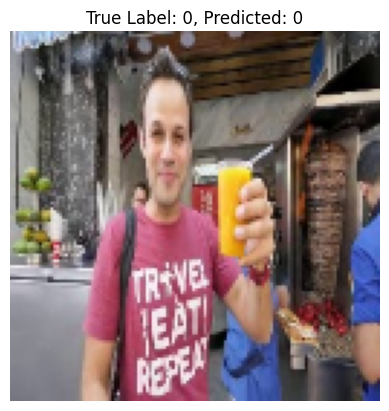

True Label: 0
Predicted Label: 0


In [62]:
random_index = random.randint(0, len(x_test) - 1)
random_image = x_test[random_index]
true_label = y_test[random_index]

# Realiza la predicción
prediction = best_model.predict(random_image[np.newaxis, ...])
predicted_label = possible_labels[np.argmax(prediction)]

# Muestra la imagen junto con la etiqueta verdadera y la predicción
plt.imshow(random_image)
plt.title(f"True Label: {possible_labels[true_label]}, Predicted: {predicted_label}")
plt.axis('off')
plt.show()

print(f"True Label: {possible_labels[true_label]}")
print(f"Predicted Label: {predicted_label}")